# Recurrent Neural Network

This notebook was created by Camille-Amaury JUGE, in order to better understand RNN, LSTM, GRU principles and how they work.

(it follows the exercices proposed by Hadelin de Ponteves on Udemy : https://www.udemy.com/course/le-deep-learning-de-a-a-z/)

## Imports

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10
# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, GRU
# scikit learn
from sklearn.preprocessing import MinMaxScaler

## preprocessing

The dataset represents the google's stock price over the past 5 years. It shows the basic features of the stocks.

The train set is only compunded of 1 month.

Our aim is to make prediction over the trends that the google's stock could have in the futur.

In [269]:
df_train = pd.read_csv("Google_Stock_Price_Train.csv")
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [270]:
df_test = pd.read_csv("Google_Stock_Price_Test.csv")
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [271]:
df_train.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [272]:
df_test.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [273]:
df_train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [274]:
df_test.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [275]:
df_train["Close"] = np.array([i.replace(",","") for i in df_train["Close"]]).astype(float)
df_train["Volume"] = np.array([i.replace(",","") for i in df_train["Volume"]]).astype(float)

df_test["Volume"] = np.array([i.replace(",","") for i in df_test["Volume"]]).astype(float)

In [276]:
df_train.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [277]:
df_test.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [278]:
df_train.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,533.71,151.90,279.12,404.12,537.47,654.92,816.68
High,1258.0,537.88,153.01,281.21,406.76,540.75,662.59,816.68
Low,1258.0,529.01,150.55,277.22,401.76,532.99,644.80,805.14
Close,1258.0,712.67,164.75,491.20,576.74,695.68,782.10,1216.83
Volume,1258.0,3158106.76,2273725.58,7900.00,1621700.00,2566150.00,4122500.00,24977900.00


In [279]:
df_test.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Open,20.0,807.53,15.13,778.81,802.96,807.00,809.56,837.81
High,20.0,811.93,14.38,789.63,806.74,808.64,817.10,841.95
Low,20.0,801.95,13.28,775.80,797.43,801.53,804.48,827.01
Close,20.0,807.90,13.21,786.14,802.28,806.11,810.76,835.67
Volume,20.0,1659895.00,677474.74,919300.00,1248500.00,1418050.00,1743400.00,3246600.00


Data are quite centered around the mean (regarding median ~ mean), it seems that there are no outliers then we can pre-suppose that the evolution is more or less linear.

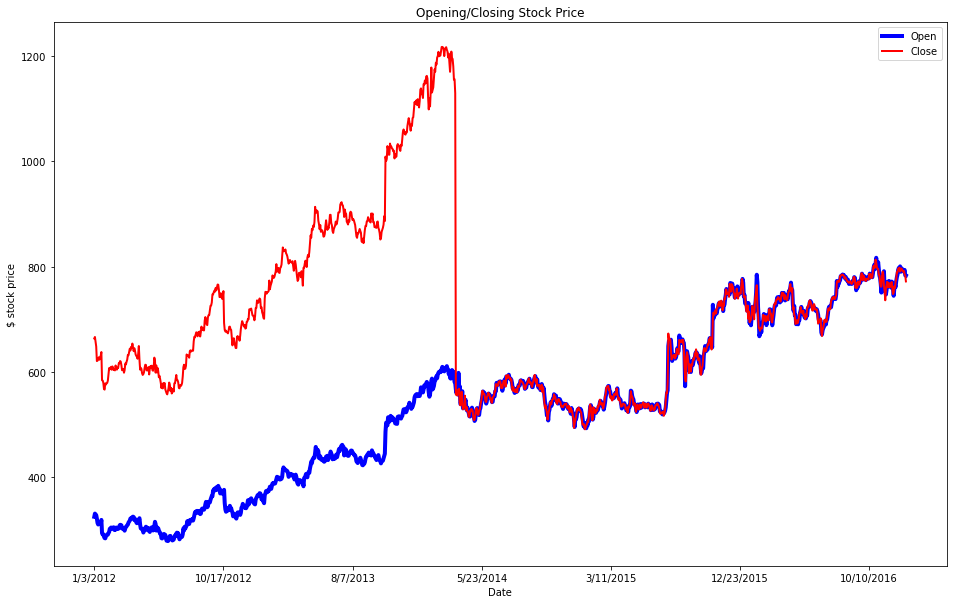

In [280]:
plt.title("Opening/Closing Stock Price")
plt.xlabel("Date")
plt.ylabel("$ stock price")
plt.xticks(np.arange(0, len(df_train["Date"]), 200)) 
plt.plot()
plt.plot(df_train["Date"], df_train["Open"], color='blue', linewidth=4, label="Open")
plt.plot(df_train["Date"], df_train["Close"], color='red', linewidth=2, label="Close")
plt.legend()

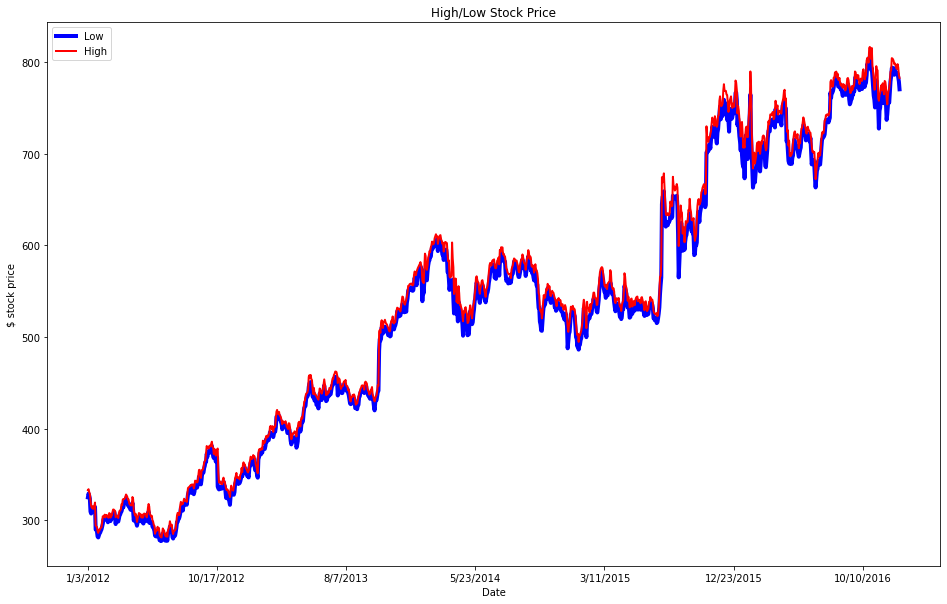

In [281]:
plt.title("High/Low Stock Price")
plt.xlabel("Date")
plt.ylabel("$ stock price")
plt.xticks(np.arange(0, len(df_train["Date"]), 200)) 
plt.plot(df_train["Date"], df_train["Low"], color='blue', linewidth=4, label="Low")
plt.plot(df_train["Date"], df_train["High"], color='red', linewidth=2, label="High")
plt.legend()

We cn observe a strange behavior on the data regarding to the close price. It seems that the data are not accurate until 23-5-2014

we are going to scale the feature.

In [282]:
X_train = df_train[["Open"]].values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

We are going to create timesteps in order to give a row the last days values : 
here we will choose two month (~60 days)

In [283]:
_days_range = 60

In [284]:
X_train = []
y_train = []
for i in range(_days_range, X_train_scaled.shape[0]):
    X_train.append(X_train_scaled[i-_days_range:i, 0])
    y_train.append(X_train_scaled[i, 0])

In [285]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [286]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [287]:
X_train[0]

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       [0.09156187],
       [0.07984225],
       [0.0643277 ],
       [0.0585423 ],
       [0.06568569],
       [0.06109085],
       [0.06639259],
       [0.0614257 ],
       [0.07474514],
       [0.02797827],
       [0.02379269],
       [0.02409033],
       [0.0159238 ],
       [0.01078949],
       [0.00967334],
       [0.01642607],
       [0.02100231],
       [0.02280676],
       [0.02273235],
       [0.02810849],
       [0.03212665],
       [0.0433812 ],
       [0.04475779],
       [0.04790163],
       [0.0440695 ],
       [0.04648783],
       [0.04745517],
       [0.04873875],
       [0.03936305],
       [0.04137213],
       [0.04034898],
       [0.04784582],
       [0.04325099],
       [0.04356723],
       [0.04286033],
       [0.04602277],
       [0.05398467],
       [0.05738894],
       [0.05714711],
       [0.05569611],
       [0.04421832],
       [0.04514845],
       [0.04605997],
       [0.04412531],
       [0.036

In [288]:
df = pd.concat([df_train["Open"], df_test["Open"]], axis = 0)
len(df)

1278

In [289]:
X_test = df[df.shape[0]-df_test.shape[0]-_days_range:].values
X_test = X_test.reshape(-1,1)
X_test_scaled = scaler.transform(X_test)

In [290]:
X_test = []
for i in range(_days_range, X_test_scaled.shape[0]):
    X_test.append(X_test_scaled[i-_days_range:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [291]:
X_test.shape

(20, 60, 1)

In [292]:
X_test[19]

array([[0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.95762334],
       [0.96413424],
       [0.96402262],
       [0.96971501],
       [0.95077759],
       [0.96294367],
       [0.96123223],
       [0.95475854],
       [0.95204256],
       [0.95163331],
       [0.95725128],
       [0.93796041],
       [0.93688146],
       [0.92955205],
       [0.94731751],
       [0.94307612],
       [0.96015329],
       [0.98087655],
       [0.98359253],
       [0.978

## Model

### LSTM

In [305]:
def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=128))
    model.add(Dense(units=64))
    model.add(Dense(units=1))
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [306]:
model = lstm_model((X_train.shape[1],1))

In [307]:
model.fit(X_train, y_train, epochs=50, batch_size = 32)

Epoch 1/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0211
Epoch 2/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0035
Epoch 3/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0026
Epoch 4/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0028
Epoch 5/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0019
Epoch 6/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0021
Epoch 7/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0019
Epoch 8/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0021
Epoch 9/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0023
Epoch 10/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0017
Epoch 11/50
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0016
Epoch 12/50
1198/1198 [==============================] - 16s 13

In [308]:
y_pred = model.predict(X_test)

In [309]:
y_pred_real = scaler.inverse_transform(y_pred)

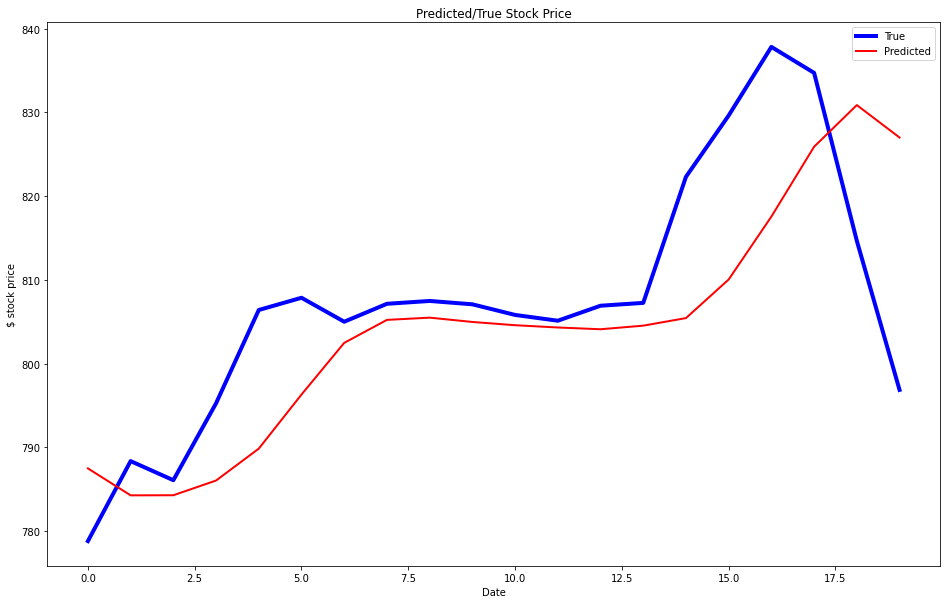

In [310]:
plt.title("Predicted/True Stock Price")
plt.xlabel("Date")
plt.ylabel("$ stock price")
plt.plot()
plt.plot(df_test["Open"], color='blue', linewidth=4, label="True")
plt.plot(y_pred_real, color='red', linewidth=2, label="Predicted")
plt.legend()

### GRU

In [312]:
def gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(units=128))
    model.add(Dense(units=64))
    model.add(Dense(units=1))
    
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])
    return model

In [313]:
model = gru_model((X_train.shape[1],1))

In [314]:
model.fit(X_train, y_train, epochs=50, batch_size = 32)

Epoch 1/50
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 2/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 3/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 4/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 5/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 6/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 7/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 8/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/50
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0016 - m

In [315]:
y_pred = model.predict(X_test)

In [316]:
y_pred_real = scaler.inverse_transform(y_pred)

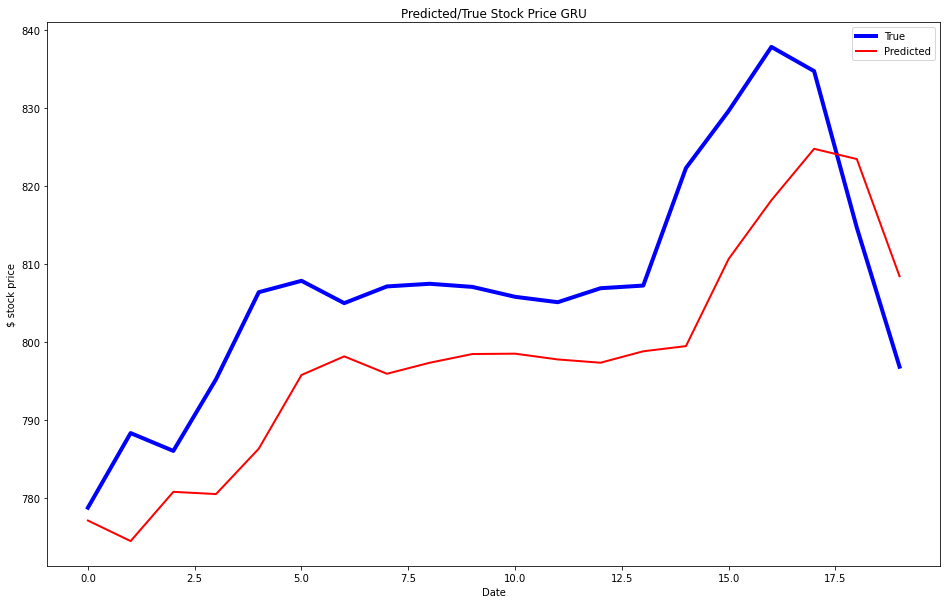

In [317]:
plt.title("Predicted/True Stock Price GRU")
plt.xlabel("Date")
plt.ylabel("$ stock price")
plt.plot()
plt.plot(df_test["Open"], color='blue', linewidth=4, label="True")
plt.plot(y_pred_real, color='red', linewidth=2, label="Predicted")
plt.legend()